这里会展示使用 EM Algorithm 求解 GMM 中参数, 其中假设 方差是已知的.

- **GMM**

    em

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

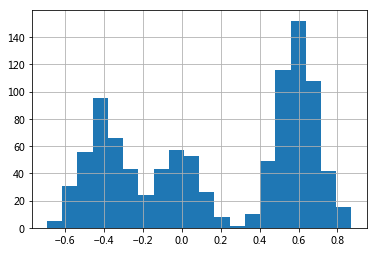

In [2]:
# 原始数据
data = pd.read_csv("./notes-on-dirichlet-processes/clusters.csv", header=None, index_col=0)[1]
data_labels = pd.read_csv("./notes-on-dirichlet-processes/cluster_labels.csv", header=None, index_col=0)[1]

_=data.hist(bins=20)

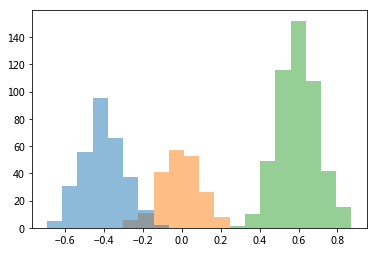

In [3]:
def plot_clusters(data_points, data_assigns):
    gby = pd.DataFrame({
            'data': data_points, 
            'assignment': data_assigns}
        ).groupby(by='assignment')['data']
    hist_data = [gby.get_group(cid).tolist() 
                 for cid in gby.groups.keys()]
    plt.hist(hist_data, 
             bins=20,
             histtype='stepfilled', alpha=.5 )

# 真实的 cluster label下绘制的直方图
plot_clusters(data, data_labels)

### 使用 EM Algorithm 求解 GMM

现假设方差已知 $\sigma^2 = 0.01$

观测到的数据为 $ x_1, x_2, ..., x_n $, 相应的隐含类别为 $ z_1, ..., z_n $.

待估计的参数为 $\theta = (\alpha_1, ..., \alpha_K, u_1, ..., u_K)$, 其中 $K$ 为 cluster 的数目.

EM Algorithm 的迭代公式如下:

- **E-step**:

$$ p(z_i|x_i, \theta^{old}) = \frac{\alpha_{z_{i}}N(x_{i}|u_{z_{i}}, \sigma^2)}{\sum_{l=1}^{k}\alpha_{l}N(x_{i}|u_{l}, \sigma^2) } $$

- **M-step**:

$$ \alpha_{l} = \frac {\sum_{j=1}^{n} p(l | x_{j}, \theta^{old})}{n} $$
    
$$ u_{l} = \frac {\sum_{j=1}^{n} p(l | x_{j}, \theta^{old}) x_{j}} {\sum_{j=1}^{n} p(l | x_{j}, \theta^{old})} $$

In [4]:
from scipy.stats import dirichlet, norm

class GMM:
    
    def __init__(self, n_clusters=3, variance=0.01):
        self.n_clusters = n_clusters
        self.variance = variance
        self.std = np.sqrt(self.variance)
        
        self.means = norm().rvs(n_clusters)
        self.alphas = dirichlet([1] * n_clusters).rvs(1)[0]

    def fit(self, data, num_epoches=100):
        data_size = data.shape[0]
        std = np.sqrt(self.variance)

        responsibility = np.zeros_like([data_size, self.n_clusters])
        for i_epoch in range(num_epoches):
            # e-step
            responsibility = np.array([self.calc_prob(data[data_i]) for data_i in range(data_size)])
            responsibility = np.divide(responsibility, responsibility.sum(axis=1)[:, np.newaxis])

            # m-step
            responsibility_sum = responsibility.sum(axis=0)
            self.alphas = responsibility_sum / data_size
            self.means = (responsibility * data.values[:, np.newaxis]).sum(axis=0) / responsibility_sum        

    def calc_prob(self, data_point):
        probs = np.array([norm.pdf(data_point, loc=self.means[cluster_i], scale=self.std) for cluster_i in range(self.n_clusters)])
        return probs

    def predict_pdf(self, data_point):
        probs = self.calc_prob(data_point)
        return np.sum(probs * self.alphas)
    
    def predict_prob(self, data_point):
        probs = self.calc_prob(data_point)
        return np.divide(probs, probs.sum())

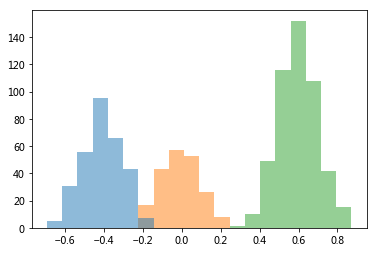

In [5]:
gmm = GMM()
gmm.fit(data)

# 使用 em 求解出来的数据的直方图
data_assigns = [gmm.predict_prob(data_point=data_item).argmax() for data_item in data]
plot_clusters(data, data_assigns)